# ECE 43800: Lab 3 -- Number Representation and Waveform Quantization
## Name: Jin Hyung Park
## Section: 003

# 1. Introduction
This lab presents two important concepts for working with digital signals. The first section discusses how numbers are stored in memory. Numbers may be either in fixed point or floating point format. Integers are often represented with fixed point format. Decimals and numbers that may take on a very large range of values would use floating point. The second issue of numeric storage is quantization. All analog signals that are processed on the computer must first be quantized. We will examine the errors that arise from this operation and determine how diﬀerent levels of quantization aﬀect a signal’s quality. We will also look at two types of quantizers. The **uniform quantizer** is the simpler of the two. The **max quantizer** is optimal, in that it minimizes the mean square error between the original and quantized signals.

Before moving on to the next section, **be sure to run the cells below** to load the libraries required for this lab.

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd
from helper import xcorr, lloyds

In [182]:
# make sure the plot is displayed in this notebook
%matplotlib inline
# specify the size of the plot
plt.rcParams['figure.figsize'] = (16, 6)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Review of Number Representations
There are two types of numbers that a computer can represent: integers and decimals. These two numbers are stored quite diﬀerently in memory. Integers (e.g., $27, 0, −986$) are usually stored in fixed point format, while decimals (e.g. $12.34, -0.98$) most often use floating point format. Integer representations can use different amounts of memory depending on the range required; the most common are one, two, four, or eight bytes per integer. Floating point representations can use different amounts of memory depending on the precision required; the most common are four or eight bytes per number.

There are diﬀerent conventions for encoding fixed point binary numbers because of the diﬀerent ways of representing negative numbers. Three
types of fixed point formats that accommodate negative integers are **sign-magnitude**, **one’s-complement**, and **two’s-complement**. In all three of these "signed" formats, the first bit denotes the sign of the number: 0 for positive, and 1 for negative. For positive numbers, the magnitude simply follows the first bit. Negative numbers are handled diﬀerently for each format.

Of course, there is also an unsigned data type which can be used when the numbers are known to be non-negative. This allows a greater range of possible numbers since a bit isn’t wasted on the negative sign.

## 2.1. Sign-Magnitude Representation
Sign-magnitude notation is the simplest way to represent negative numbers. The magnitude of the negative number follows the first bit. If an integer was stored as one byte, the range of possible numbers would be $−127$ to $127$.

In this format, the value $+27$ would be represented as: `00011011`, and the value $-27$ would be represented as: `10011011`.

## 2.2. One's-Complement Representation
To represent a negative number, the complement of the bits for the positive number with the same magnitude are computed.

In this format, the value $+27$ would be represented as: `00011011`, and the value $-27$ would be represented as `11100100`.

## 2.3. Two's-Complement Representation
The problem with each of the above notations is that two diﬀerent values represent zero. Consider how to write $\pm 0$ in both forms above. 
Two's-complement notation is a revision to one's-complement that solves this problem. To form negative numbers, the positive number is subtracted from a certain binary number. This number has a one in the most significant bit (MSB), followed by as many zeros as there are bits in the representation. 

For 8-bit integers in this format, the value $-27$ would be represented as
```
 100000000
- 00011011
= 11100101
```

Notice that this result is one plus the one's-complement representation for $-27$ (modulo-2 addition). What about the second value of $0$? That representation is `10000000`. This value equals $-128$ in two's-complement representation!
```
 100000000
- 10000000
= 10000000
```

The value represented here is $-128$; we know it is negative, because the result has a $1$ in the MSB. Two's-complement is used because it can represent one extra negative value. More importantly, if the sum of a series of two's-complement numbers is within the range, overflows that occur during the summation will not aﬀect the final answer! The range of an 8-bit two's-complement integer is $[-128,127]$.

## 2.4. Floating Point
Floating point notation is used to represent a much wider range of numbers. The tradeoﬀ is that the resolution is variable: it decreases as the magnitude of the number increases. In the fixed point examples above, the resolution was fixed at $1$. It is possible to represent decimals with fixed point notation, but for a fixed word length any increase in resolution is matched by a decrease in the range of possible values.

A floating point number $F$ has two parts: a mantissa $M$ and an exponent $E$, related by $F = M \cdot 2^E$. The mantissa is a signed fraction, which has a power of two in the denominator. The exponent is a signed integer, which represents the power of two that the mantissa must be multiplied by. These signed numbers may be represented with any of the three fixed-point number formats. The IEEE
has a standard for floating point numbers (IEEE 754). For a 32-bit float, the first bit is the mantissa's sign. The exponent takes up the next 8 bits ($1$ for the sign, and $7$ for the quantity), and the mantissa is contained in the remaining $23$ bits. The range of values for this number is $(-1.18 \times 10^{-38}, 3.40 \times 10^{38})$.

To add two floating point numbers, the exponents must be the same. If the exponents are diﬀerent, the mantissa is adjusted until the exponents match. If a very small number is added to a large one, the result may be the same as the large number! For instance, if $0.15600 \times 2^{30}$ is added to $0.62500 \times 2^{-3}$, the second number would be converted to $0.000\ldots0 \times 2^{30}$ before addition. Since the mantissa only holds $23$ binary digits, the decimal digits $625$ would be lost in the conversion. In short, the second number is rounded down to zero. In multiplication, the two exponents are added and the mantissas multiplied.

# 3. Quantization
## 3.1. Introduction to Quantization
Quantization is the act of rounding oﬀ the value of a signal or quantity to certain discrete levels. For example, digital scales may round oﬀ weight to the nearest gram. Analog voltage signals in a control system may be rounded oﬀ to the nearest volt before they enter a digital controller. Generally, all numbers need to be quantized before they can be represented in a computer. Digital images are also quantized. The gray levels in a black and white photograph must be quantized in order to store an image in a computer. The
"brightness" of the photo at each pixel is assigned an integer value between $0$ and $255$ (typically), where $0$ corresponds to black and $255$ to white. 

Since an 8-bit number can represent diﬀerent values, such an image is called an "8-bit grayscale" image. An image which is quantized to just
one bit per pixel (in other words only black and white pixels) is called a halftone image. Many printers work by placing, or not placing, a spot of colorant on the paper at each point. To accommodate this, an image must be halftoned before it is printed.

Quantization can be thought of as a functional mapping $y = f(x)$ of a real-valued input to a discrete-valued output. An example of a quantization function is shown below, where the $x$-axis is the input value and the $y$-axis is the quantized output value.

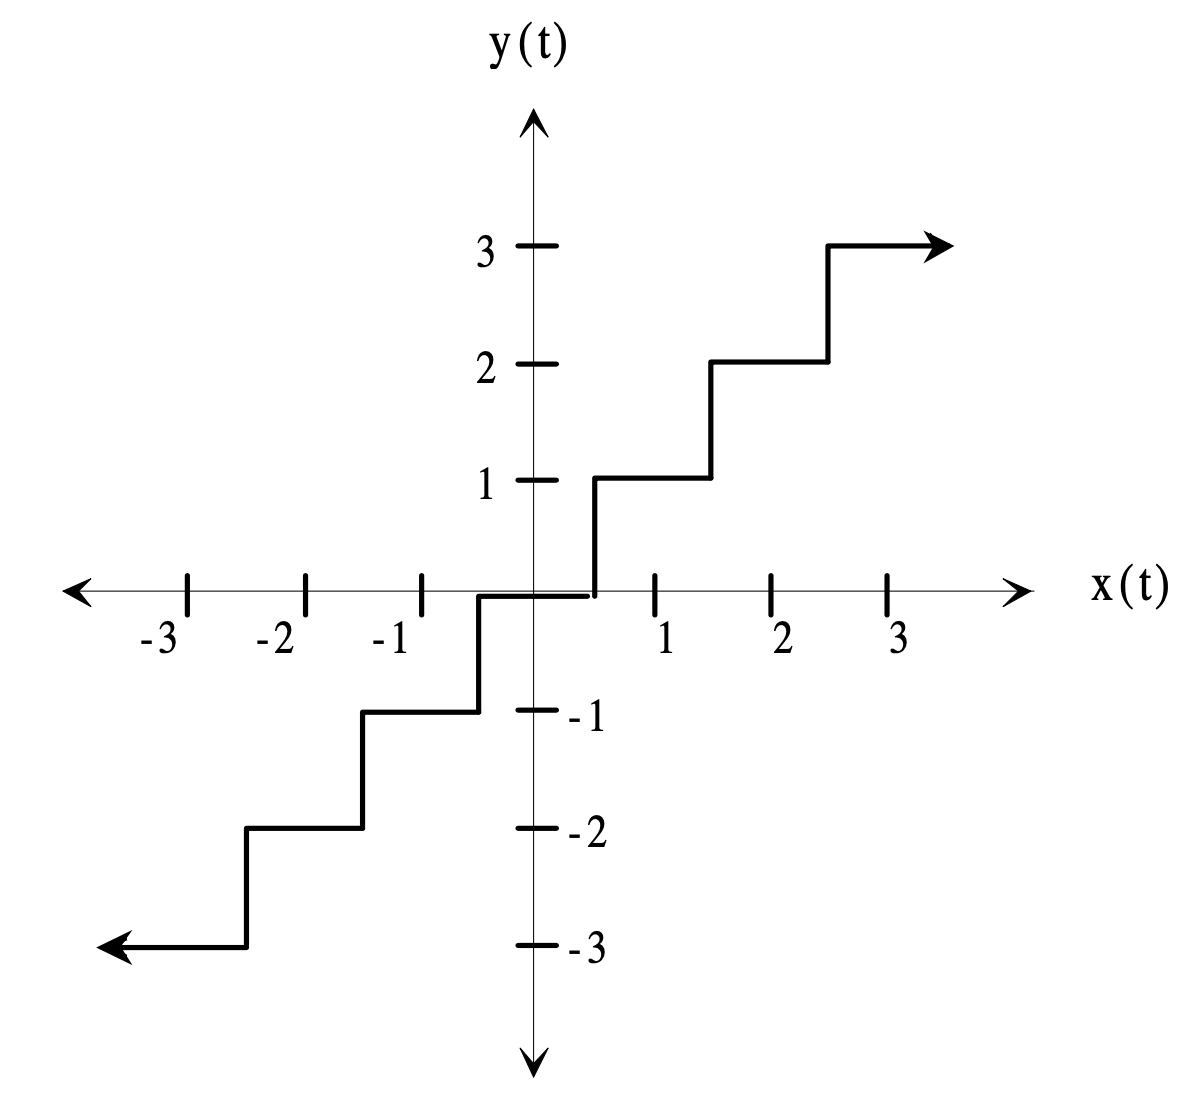

## 3.2. Quantization and Compression
Quantization is sometimes used for compression. As an example, suppose we have a digital image which is represented by 8 diﬀerent gray levels: $[0, 31, 63, 95, 159, 191, 223, 225]$. To directly store each of the image values, we need at least 8-bits for each pixel since the values range from $0$ to $255$. However, since the image only takes on 8 diﬀerent values, we can assign a diﬀerent 3-bit integer (a code) to represent each pixel: $[000, 001, \ldots, 111]$. Then, instead of storing the actual gray levels, we can store the 3-bit code for each pixel. A look-up table, possibly stored at the beginning of the file, would be used to decode the image. This lowers the cost of an image considerably: less hard drive space is needed, and less bandwidth is required to transmit the image (i.e. it downloads quicker). In practice, there are much more sophisticated methods of compressing images which rely on quantization.

## 3.3. Exercise: Image Quantization
In the assignment folder, there is an image file named `fountainbw.tif`, which contains an 8-bit grayscale image. We will investigate what happens when we quantize it to fewer bits per pixel (b/pel).

**1. Load the image and display it using the following sequence of commands.**

```python
image = plt.imread("fountainbw.tif")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.axis('image')
plt.show()
```

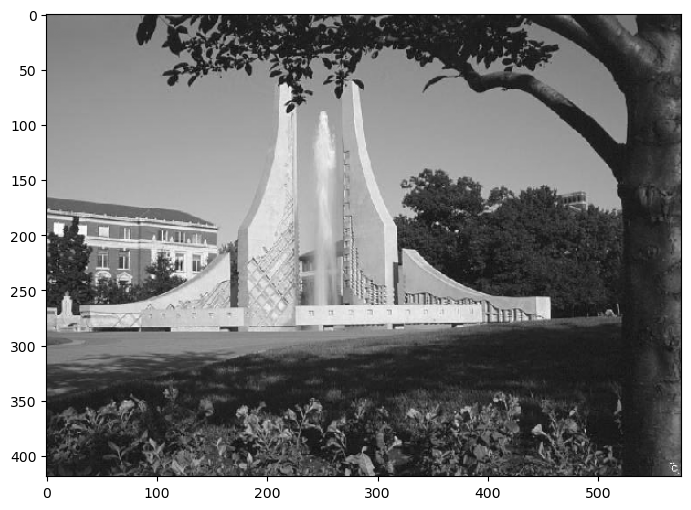

In [183]:
# insert your code here
image = plt.imread("fountainbw.tif")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.axis('image')
plt.show()

The image array will initially be of type `np.uint8`, so you will need to convert the image matrix to type `float` before performing any computation. Use the following command for this: `image = image.astype(float)`.

**2. Print the data type of this image, then convert the image matrix to type `float`, and print the data type of this image again.**

* Use `image.dtype` to get the data type of `image`.

In [184]:
# insert your code here
image.dtype
image = image.astype(float)
image.dtype

dtype('float64')

There is an easy way to uniformly quantize a signal. Let
$$\Delta = \frac{ \max X - \min X }{ N - 1 }$$
where $X$ is the signal to be quantized, and $N$ is the number of quantization levels. To force data to have a uniform quantization step of $\Delta$,
- Subtract $\min X$ from the data and divide the result by $\Delta$.
- Round the data to the nearest integer.
- Multiply the rounded data by $\Delta$ and add $\min X$ to convert the data back to its original scale.

**3. Complete the function below which will uniformly quantize an input array ```X``` (either a vector or a matrix) to a ```numBits```-bit array.**

In [185]:
def Uquant(X, numBits):
    """
    Parameters
    ---
    X: the input array to be quantized
    numBits: the number of bits. The number of quantization levels will be 2^numBits.
    
    Returns
    ---
    Y: the quantized array
    """
    N = 2**numBits
    delta = (np.max(X) - np.min(X)) / (N - 1)
    round_data = np.round((X - np.min(X)) / delta)
    Y = round_data * delta + np.min(X)
    
    # Y = None
    return Y

**4. Use this function to quantize the fountain image to $7$, $6$, $5$, $4$, $3$, $2$, $1$ b/pel, and display and observe the output images. Don't forget the titles of the images.**

* To display a grayscale image `image`, use the following commands:
```python
plt.imshow(image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
plt.title("title")
plt.show()
```

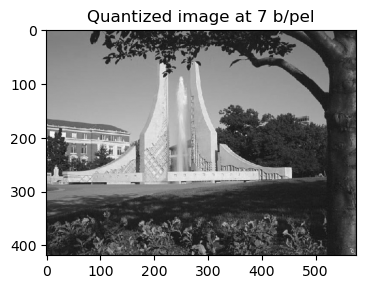

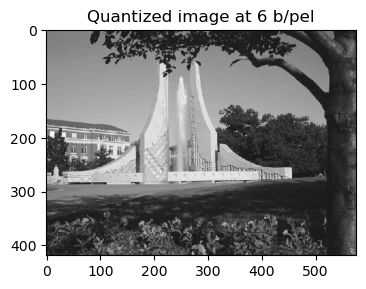

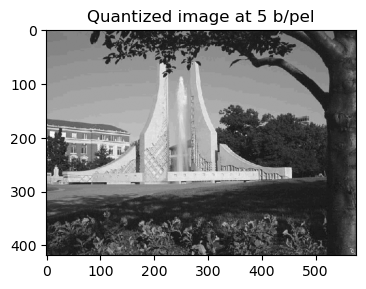

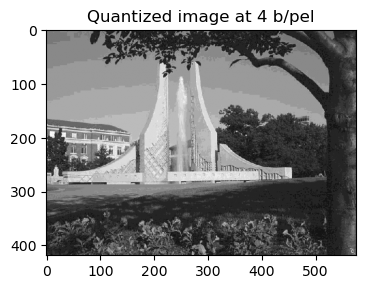

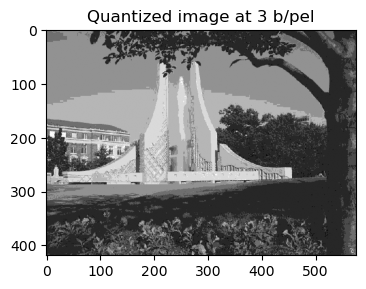

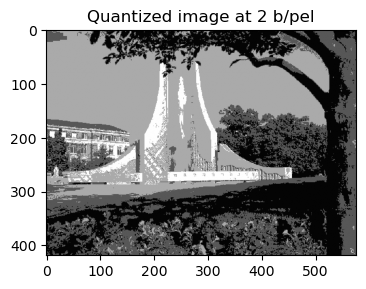

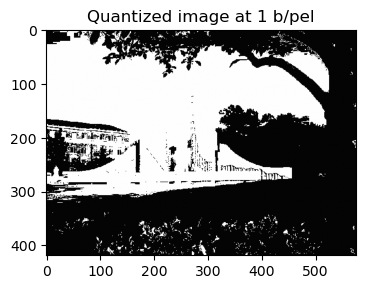

In [186]:
# insert your code here
numBits_array = [7,6,5,4,3,2,1]
plot_idx = 1

for bits in numBits_array:
    plt.figure(figsize=(30, 24))
    quan_image = Uquant(image, bits)
    plt.subplot(7,1, plot_idx)
    plt.imshow(quan_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    plot_idx += 1
    plt.title(f"Quantized image at {bits} b/pel")
    plt.show()

**5. Describe the artifacts (errors) that appear in the image as the number of bits is lowered.**

As the number of bits decreases, the image becomes less clear and can no longer represent fine intensity variations and detailed color (grayscale) combinations.

**6. Note the number of b/pel at which the image quality noticeably deteriorates.**

The noticeable deterioration occurs at 1 b/pel, since the image is represented using only two intensity levels: pure black and pure white.

**7. Compare each of four quantized images ($7$, $4$, $2$ and $1$ b/per) to the original.**

7: The image preserves nearly all details and appears very similar to the original image.
4: The image is not as clear as the 7 b/pel version or the original, but it still retains most important details.
2: Details in the trees and fountain begin to blur, and quantization artifacts become more noticeable.
1: The image no longer resembles the original, as it is reduced to only black and white. Most details are lost, making it difficult to identify the content of the image.

## 3.4. Exercise: Audio Quantization
If an audio signal is to be coded, either for compression or for digital transmission, it must undergo some form of quantization. Most often, a general technique known as vector quantization is employed for this task, but this technique must be tailored to the specific application so it will not be addressed here. In this exercise, we will observe the eﬀect of uniformly quantizing the samples of two audio signals.

**1. Use your function `Uquant()` to quantize each of these signals: ```speech.au``` and ```music.au``` to 7, 4, 2 and 1 bits/sample. Listen to the original and quantized signals.**

* To read an audio file:
```python
speech, fs = sf.read("speech.au")  # speech is the signal vector, and fs is the sampling frequency
```
* To play a signal
```python
ipd.Audio(speech, rate=fs)
```

In [187]:
# insert your code here
speech, fs_speech = sf.read("speech.au")
music, fs_music = sf.read("music.au")


quant_speech_music = [7,4,2,1]

for b in quant_speech_music:
    quant_speech = Uquant(speech, b)
    quant_music = Uquant(music, b)
    
    display(ipd.Audio(quant_speech, rate=fs_speech))
    display(ipd.Audio(quant_music, rate=fs_music))

**2. For each signal, describe the change in quality as the number of b/sample is reduced.**

7: The sound is close to the original, with minimal distortion.
4: The sound is still audible, but noticeable noise is present.
2: The sound and noise mix together, and the noise becomes very obvious.
1: The noise dominates the signal, making it difficult or impossible to identify what is being said.

**3. For each signal, is there a point at which the signal quality deteriorates drastically? At what point (if any) does it become incomprehensible?**

The signal deteriorates most noticeably at 2 bits, but the sound is still understandable. At 1 bit, the signal loses its distinctive features due to noise and becomes incomprehensible.

**4. Which signal’s quality deteriorates faster as the number of levels decreases?**

I would say that the music’s quality deteriorates faster than the speech signal. Since music has a wider spectrum and a more dynamic range with richer sound components, its quality degrades more quickly as the number of levels decreases.

**5. Do you think 4 b/sample is acceptable for telephone systems? What about 2 b/sample?**

I would say that 4 b/sample is acceptable, since the signal remains within a valid range of being comprehensible. However, at 2 b/sample, the speech becomes difficult to understand due to the increased amount of noise.

**6. Plot the four quantized `speech` signals over the index range $[7200:7400)$. Generate a similar figure for the `music` signal, using the same indices.**

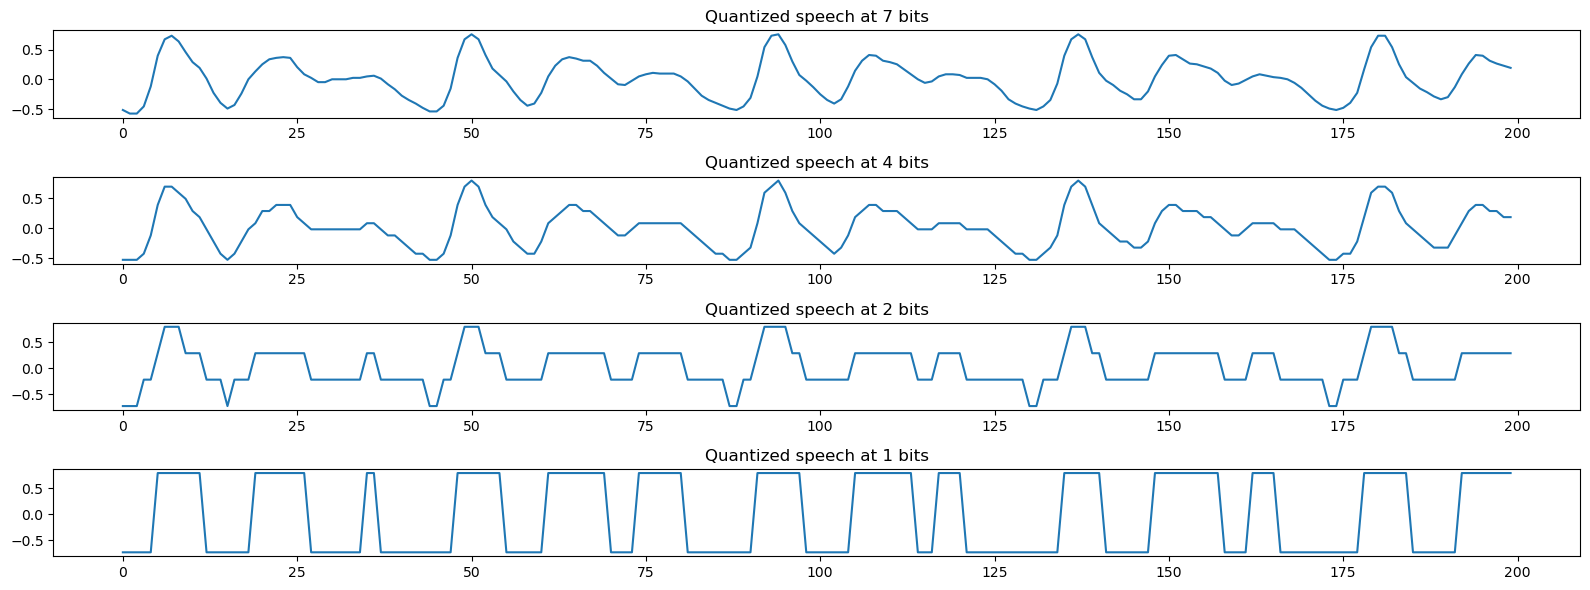

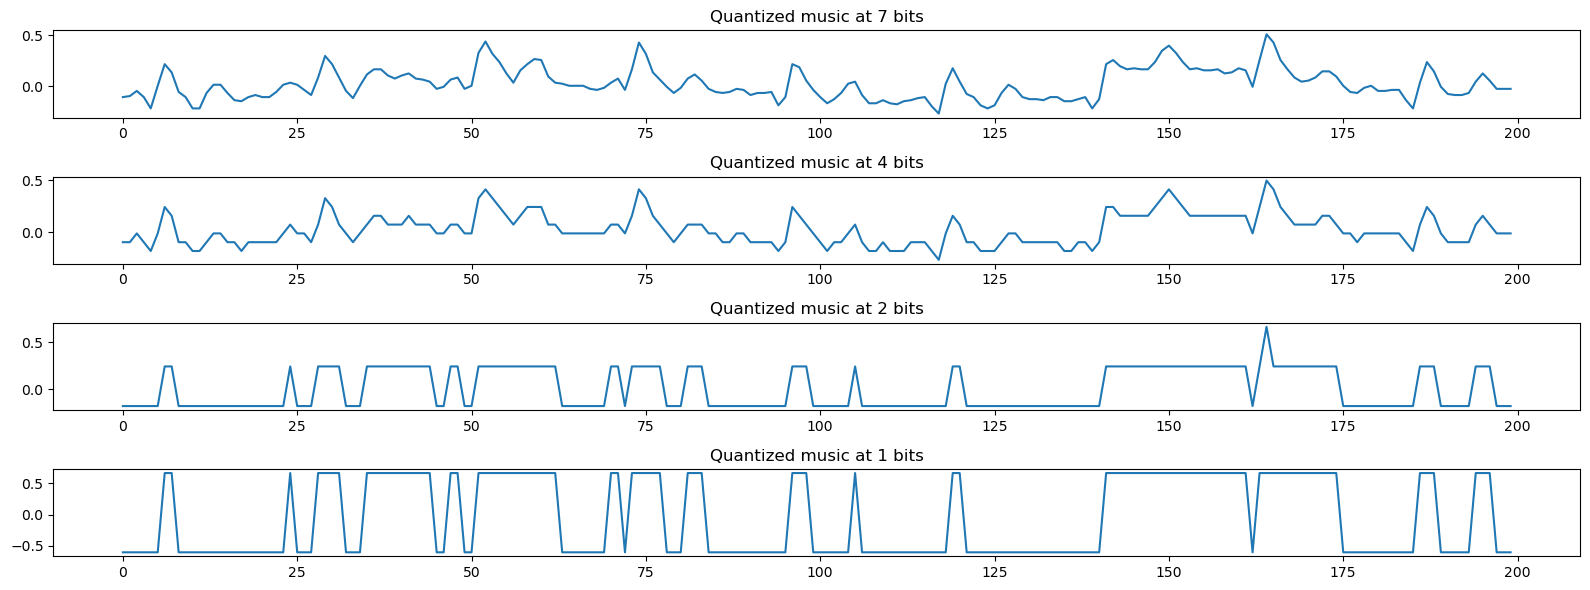

In [188]:
# insert your code here

bit_samples = [7,4,2,1]
speech_plot_index = 1
music_plot_index = 1

for samples in bit_samples:
    
    quant_speech = Uquant(speech, samples)
    plt.subplot(4, 1, speech_plot_index)
    plt.plot(quant_speech[7200:7400]) # x-axis: index
    plt.title(f"Quantized speech at {samples} bits")
    speech_plot_index += 1
plt.tight_layout()
plt.show()

for samples_music in bit_samples:
    
    quant_music = Uquant(music, samples_music)
    plt.subplot(4, 1, music_plot_index)
    plt.plot(quant_music[7200:7400]) # x-axis: index
    plt.title(f"Quantized music at {samples_music} bits")
    music_plot_index += 1
plt.tight_layout()
plt.show()

## 3.5. Exercise: Error Analysis
As we have clearly observed, quantization produces errors in a signal. The most eﬀective methods for analysis of the error turn out to be
probabilistic. In order to apply these methods, however, one needs to have a clear understanding of the error signal’s statistical properties. For example, can we assume that the error signal is white noise? Can we assume that it is uncorrelated with the quantized signal? As you will see in this exercise, both of these are good assumptions if the quantization intervals are small compared with sample-to-sample variations in the signal.

If the original signal is $X$ and the quantized signal is $Y$, the error signal is defined as:
$$E = Y - X$$

**1. Compute the error signal for the quantized speech for $7$, $4$, $2$ and $1$ b/sample.**

In [189]:
# insert your code here
# Do I need to print the computed values?
store_error = {}

for bit_error in bit_samples:
    quant_speech_error = Uquant(speech, bit_error)
    error_signal = quant_speech_error - speech
    store_error[bit_error] = error_signal

When the spacing $\Delta$ between quantization levels is sufficiently small, a common statistical model for the error is a uniform distribution from $-\frac{\Delta}{2}$ to $\frac{\Delta}{2}$.

**2. Use the command [```plt.hist(E, bins=20)```](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html) to generate 20-bin histograms for each of the four error signals.**

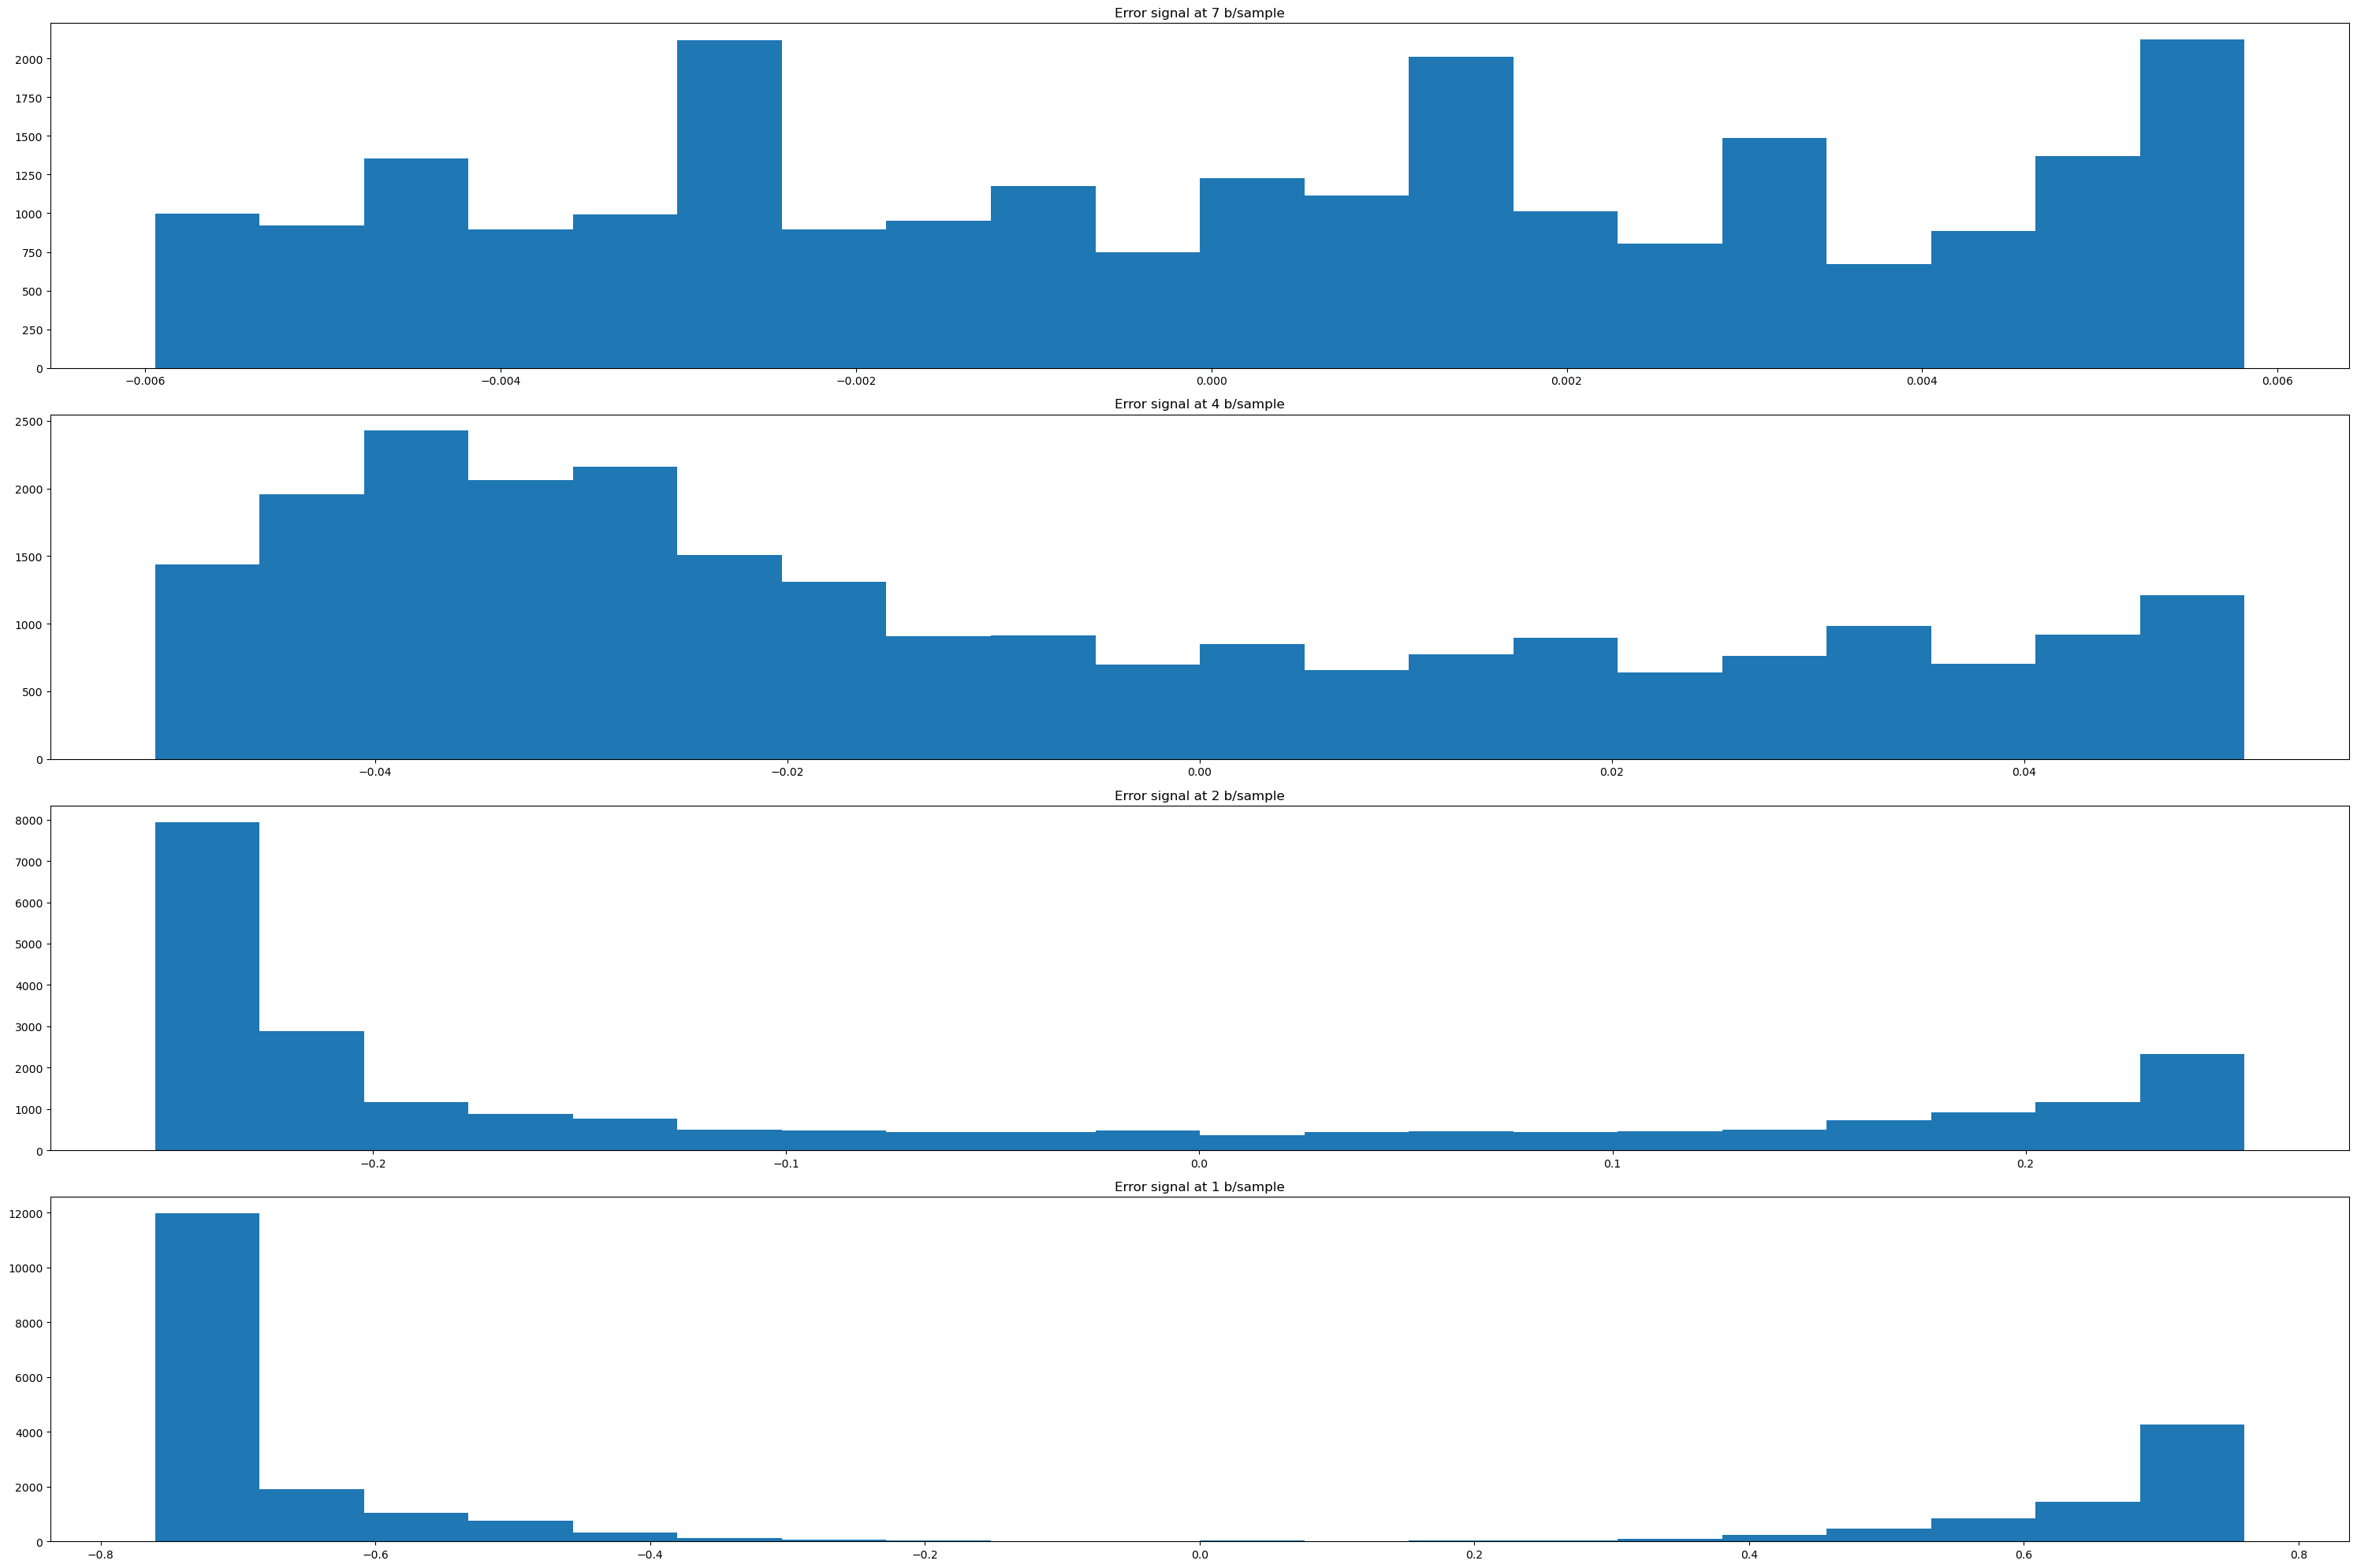

In [190]:
# insert your code here
index_count = 1

plt.figure(figsize=(30,20))
for bit_error in bit_samples:
    plt.subplot(4,1, index_count)
    plt.hist(store_error[bit_error], bins=20)
    plt.title(f"Error signal at {bit_error} b/sample")
    index_count += 1
plt.tight_layout()
plt.show()
    

**3. How does the number of quantization levels seem to affect the shape of the distribution?**

As the number of quantization levels increase, the quantization error distribution becomes more uniform and concentrated around zero. However, at the low quantization level, the error is widely distributed and far from zero.

**4. Explain why the error histograms you obtain might not be uniform?**

Because the speech signal itself is not uniformly distributed, leading to cluster around certain amplitude values. Also, at low quantization levels, it is unlikely to achieve this since the large step size causes more signal-dependent distortion.

Next, we will examine correlation properties of the error signal.

**5. Compute and plot an estimate of the autocorrelation function for each of the four error signals using the following commands:**
```python
lags, r = xcorr(E, maxlags=200)
plt.plot(lags, r)
plt.show()
```
**Hint:** function ```xcorr``` is provided in the file ```helper.py```

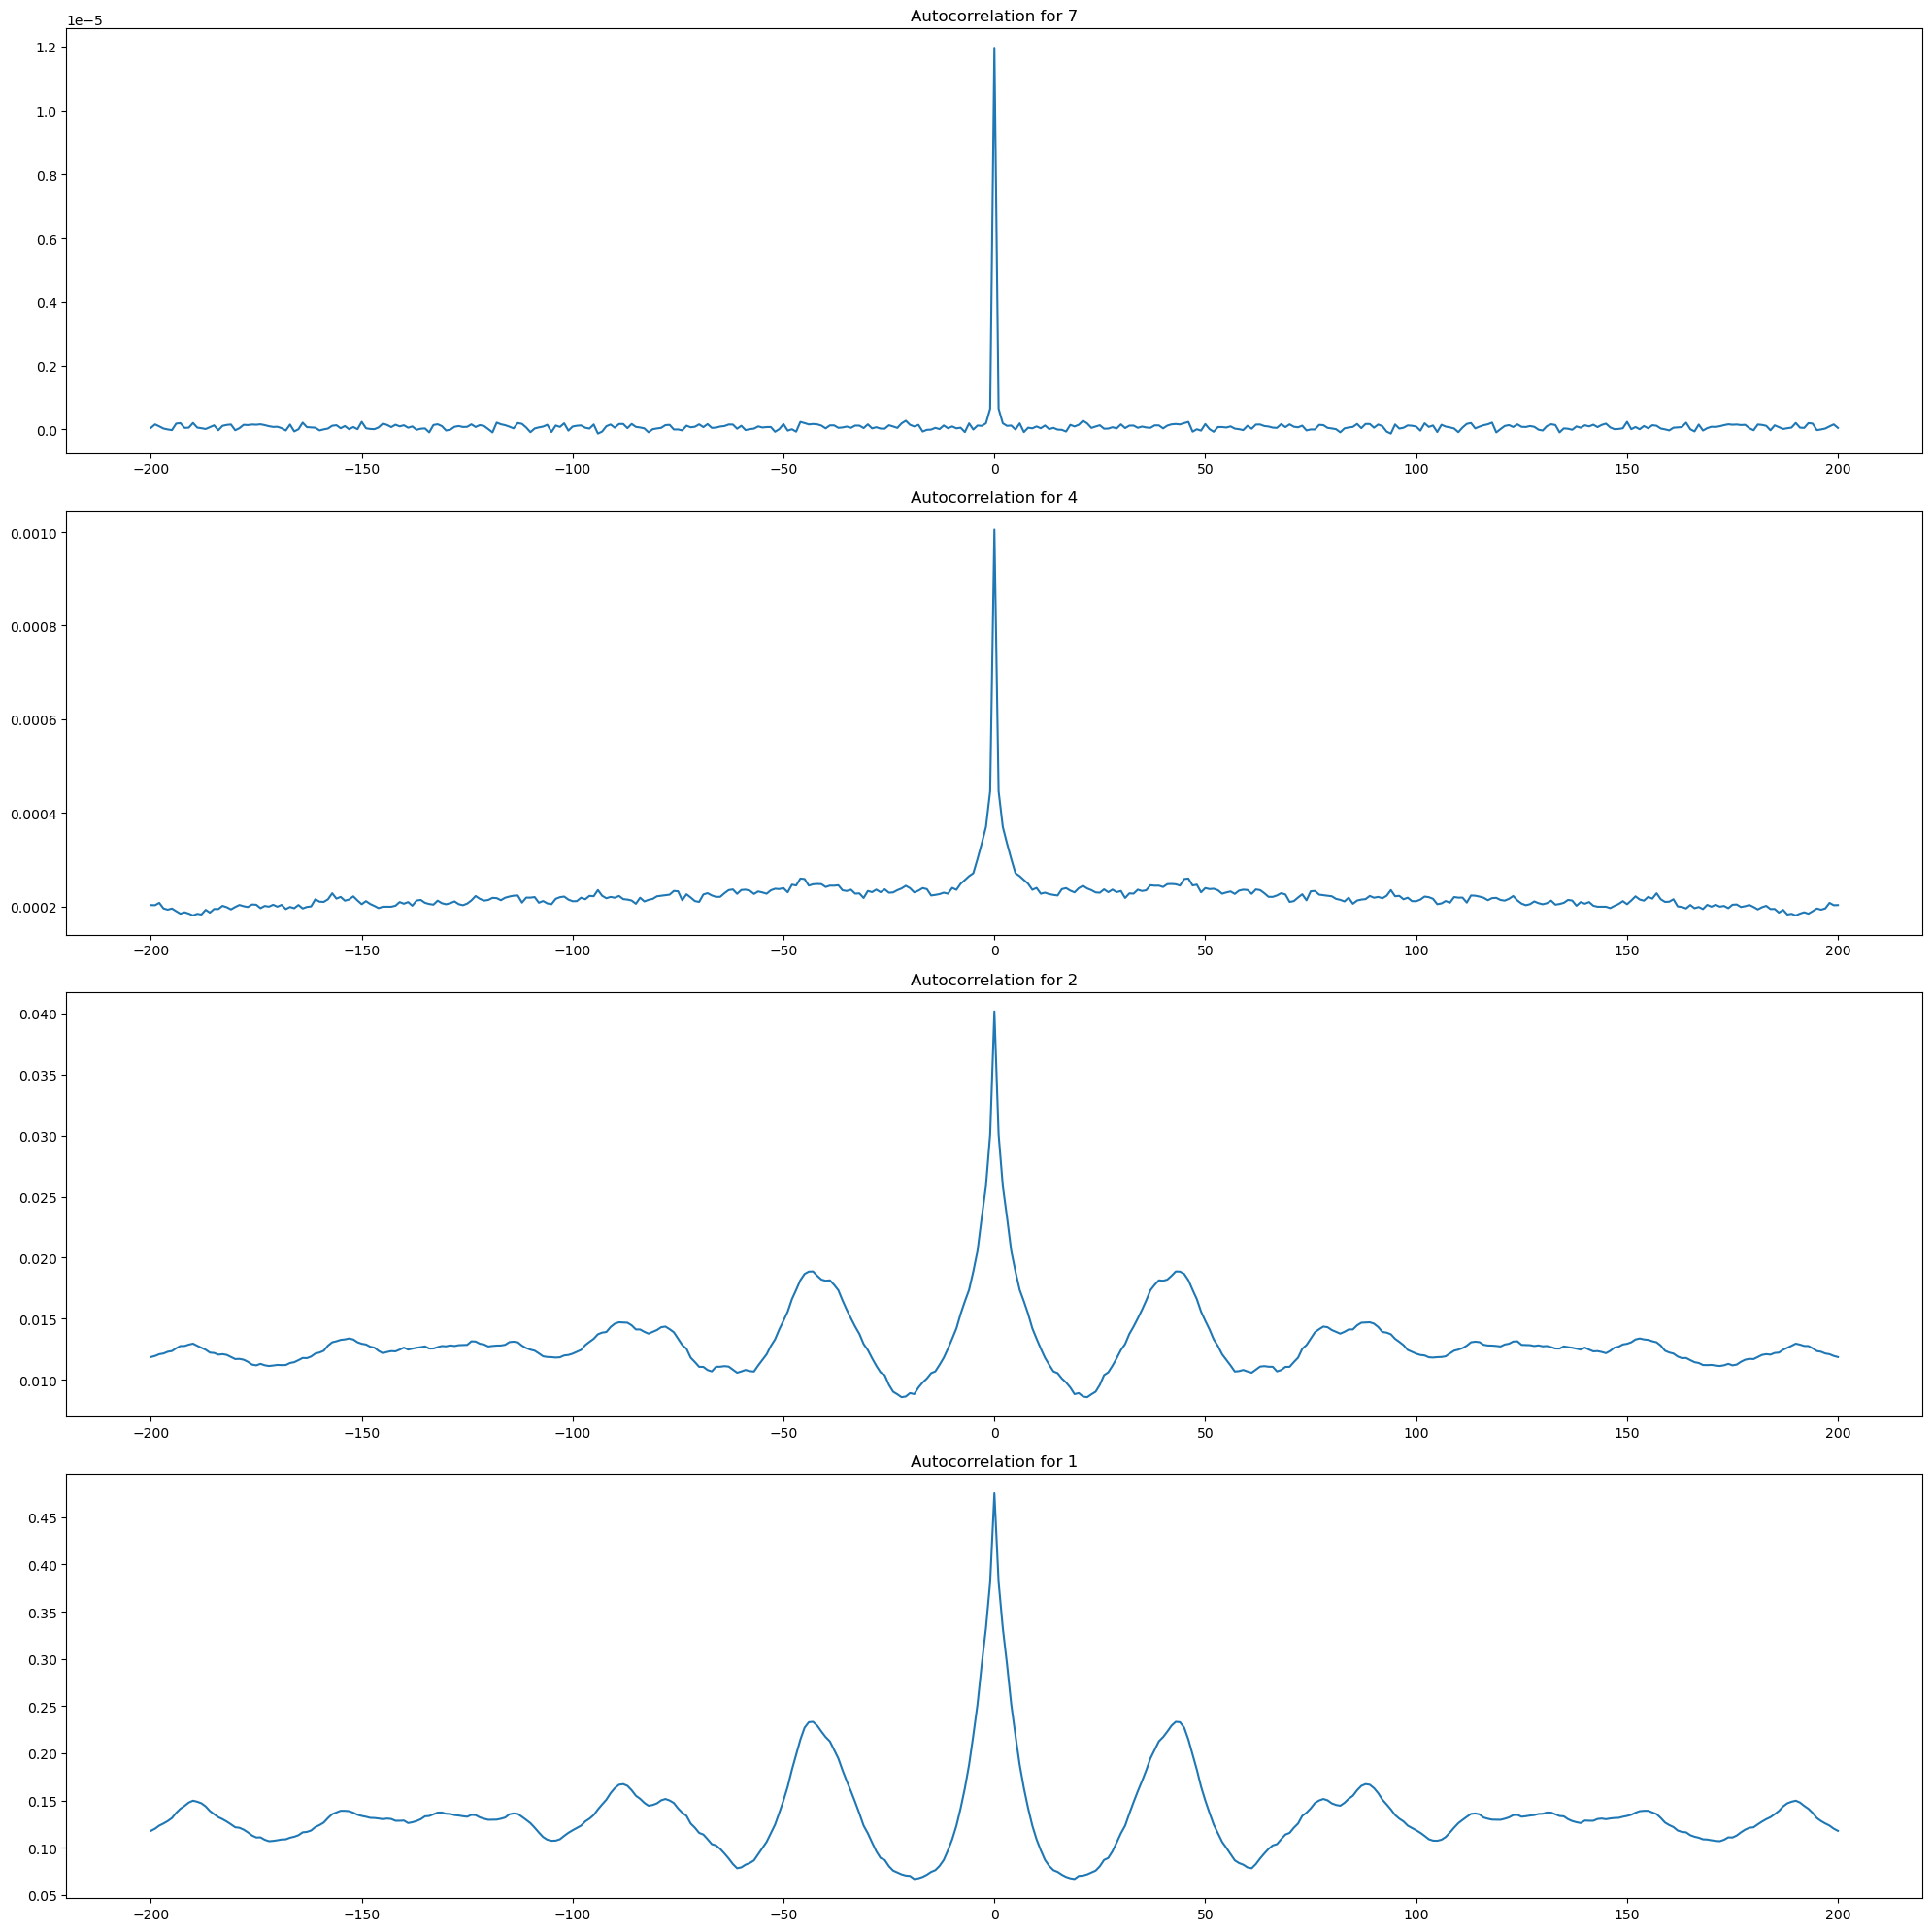

In [191]:
# insert your code here

index_auto = 1
plt.figure(figsize=(20,20))

for bit_error in bit_samples:
    plt.subplot(4,1, index_auto)
    quant_speech_error = Uquant(speech, bit_error)
    error_signal = quant_speech_error - speech
    lags, r = xcorr(error_signal, error_signal, maxlags=200)
    plt.plot(lags, r)
    plt.title(f"Autocorrelation for {bit_error}")
    index_auto += 1
    
plt.tight_layout()
plt.show()

**6. Now compute and plot an estimate of the cross-correlation function between the quantized speech $Y$ and each error signal $E$ using**
```python
lags, r = xcorr(E, Y, maxlags=200)
plt.plot(lags, r)
plt.show()
```
**Hint:** function ```xcorr``` is provided in the file ```helper.py```

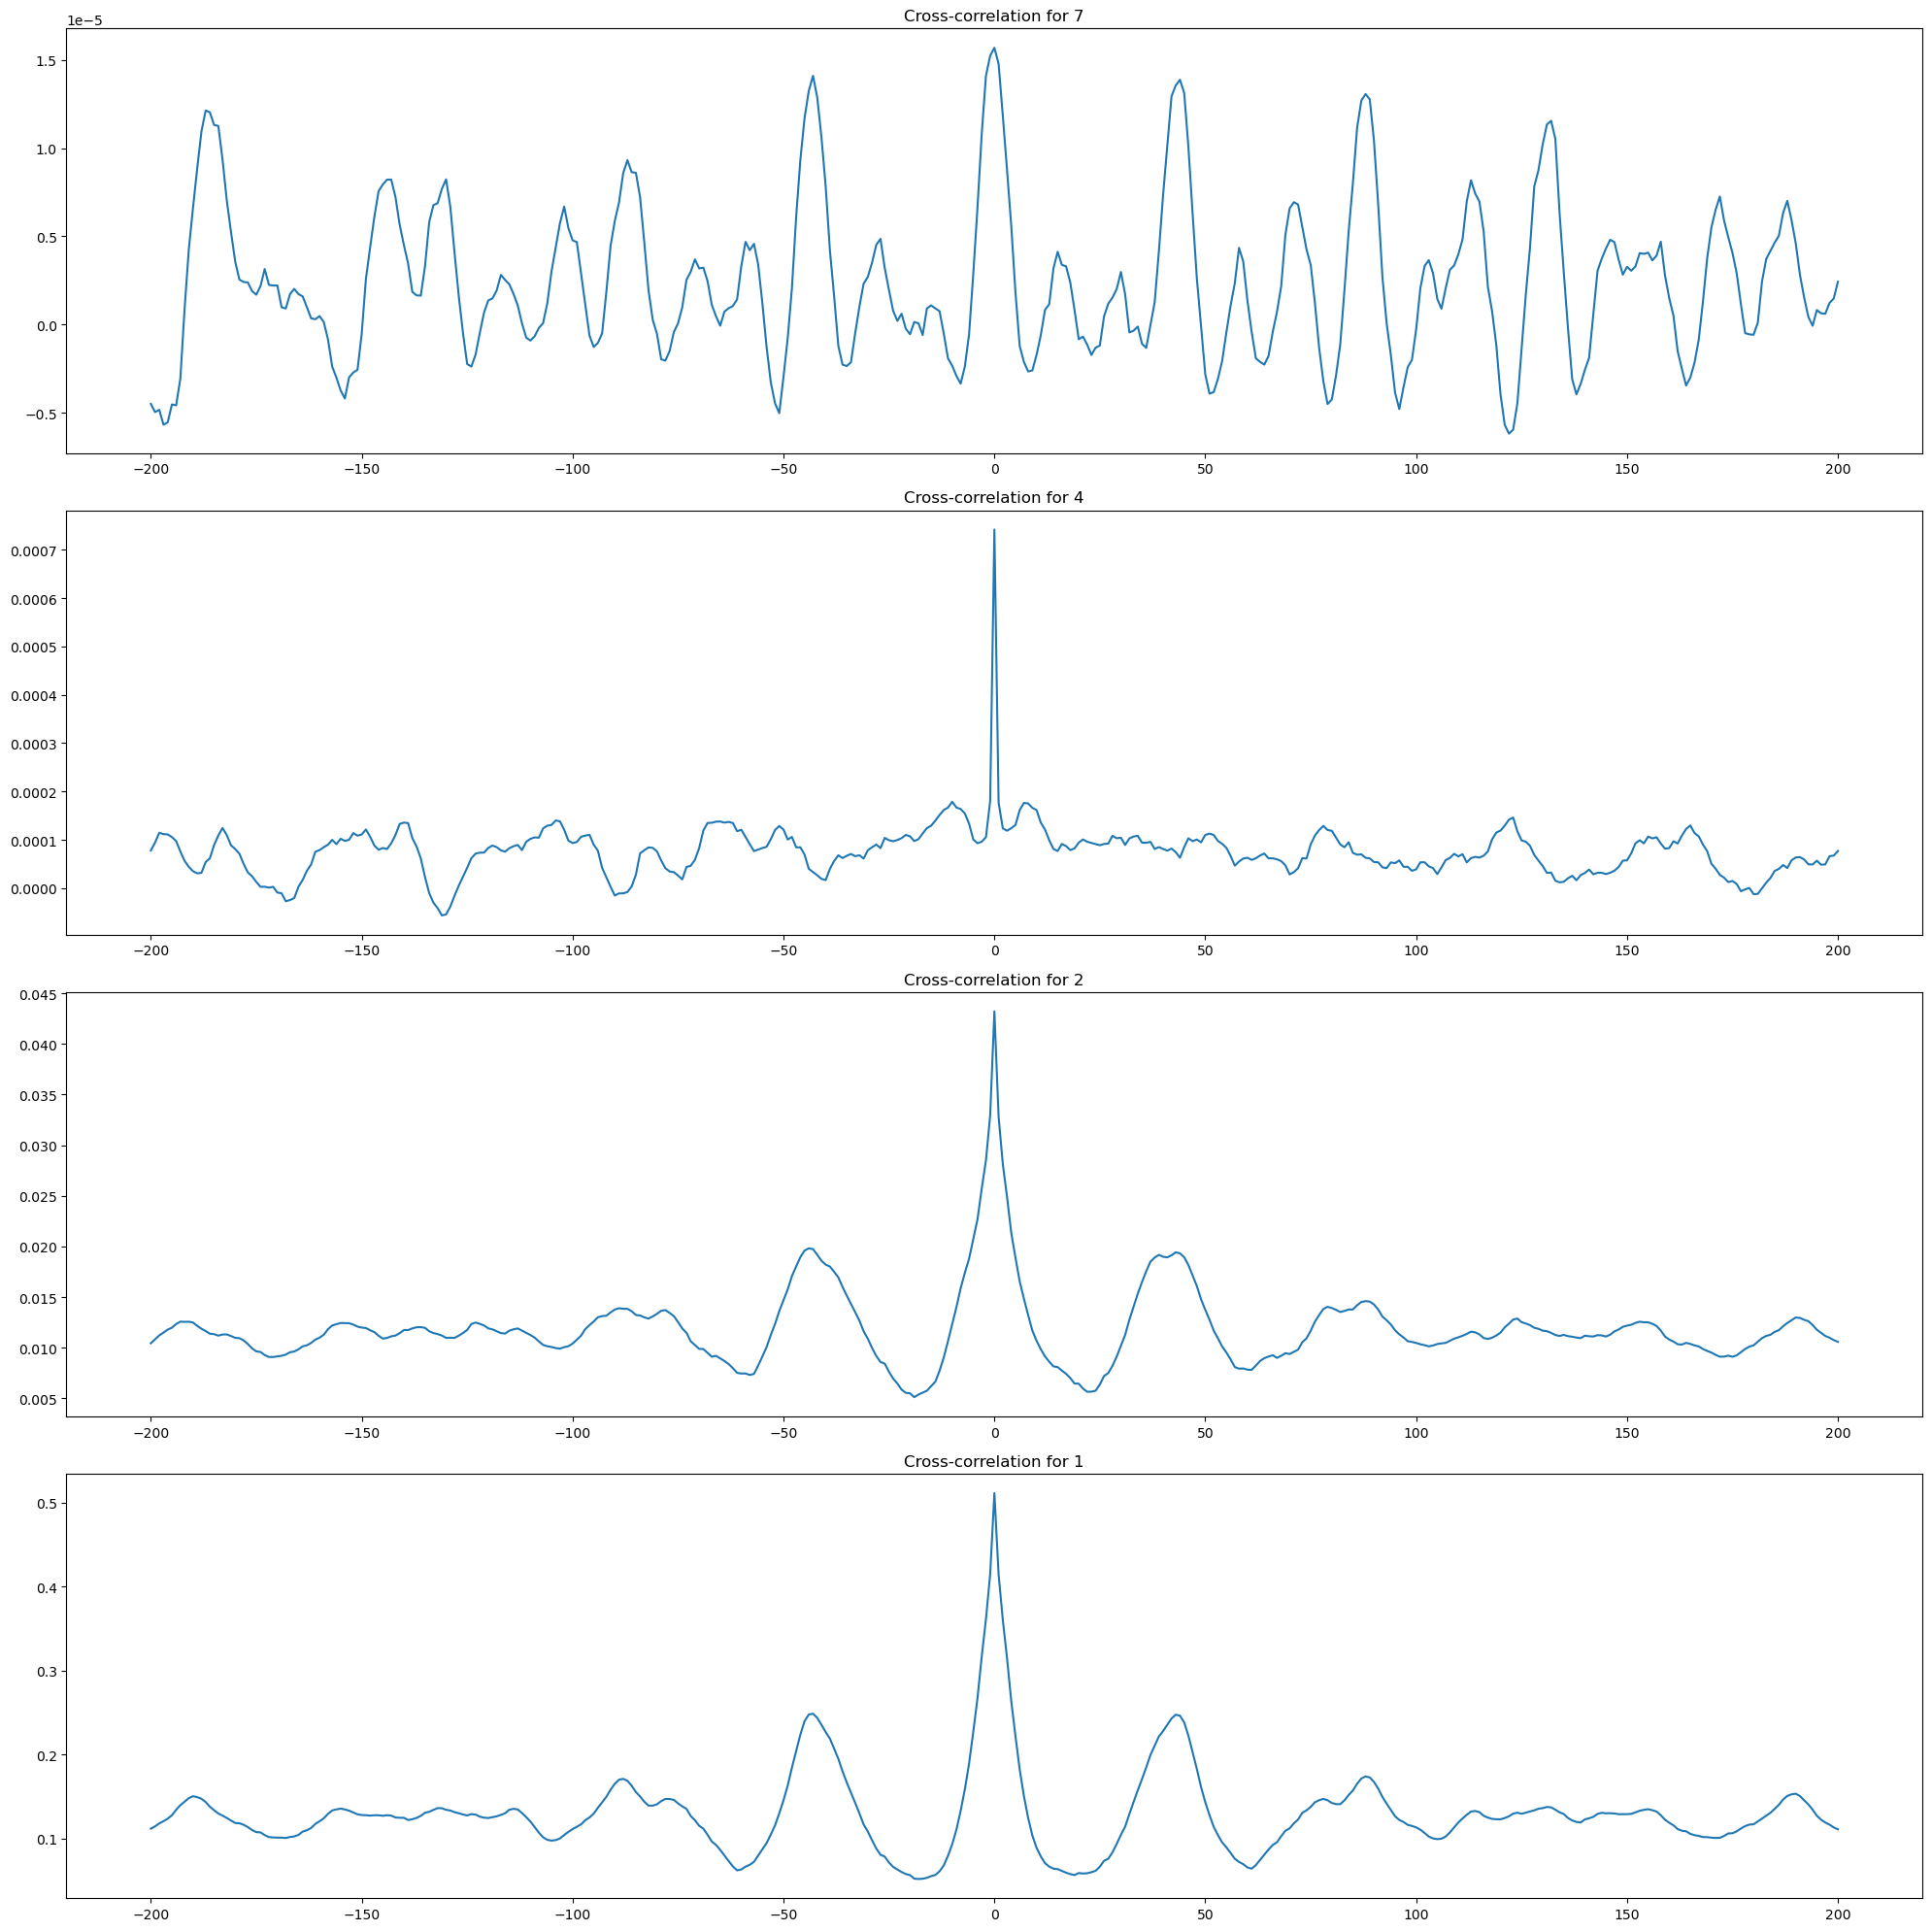

In [192]:
# insert your code here

index_cross = 1
plt.figure(figsize=(20,20))

for bit_error in bit_samples:
    plt.subplot(4,1, index_cross)
    quant_speech_error = Uquant(speech, bit_error)
    error_signal = quant_speech_error - speech
    lags, r = xcorr(error_signal, quant_speech_error, maxlags=200)
    plt.plot(lags, r)
    plt.title(f"Cross-correlation for {bit_error}")
    index_cross += 1
    
plt.tight_layout()
plt.show()

**7. Is the autocorrelation influenced by the number of quantization levels? Do samples in the error signal appear to be correlated with each other?**

Yes, as the number of quantization levels increase, the autocorrection of the error signal becomes more concentrated at zero lag, showing uncorrelated noise. Yes, the error samples seems to be correlated with each other at low quantization levels but this correlation decreases as the number of quantization levels increase.

**8. Does the number of quantization levels influence the cross-correlation?**

Yes, it does. At low quantization levels, the cross-correlation shows broader peaks and higher distortion. As the number of quantization levels increases, the quantized signal becomes more similar to the original signal, resulting in less distortion and better preservation of the original signal structure.

## 3.6. Exercise: Signal to Noise Ratio
One way to measure the quality of a quantized signal is by the Power Signal-to-Noise Ratio (PSNR). This is defined by the ratio of the power in the quantized speech to power in the noise.
$$\text{PSNR} = \frac{ P_Y }{ P_E }$$

In this expression, the noise is the error signal $E$. Generally, this means that a higher PSNR implies a less noisy signal. From previous labs, we know that the power $P_x$ of a sampled signal $x[n]$ is defined as
$$P_x = \frac{1}{L} \sum_{n=1}^L x^2[n]$$

where $L$ is the length of $x[n]$.

**1. Complete the function below that calculates the power of a sampled signal `x`.**

In [193]:
def get_power(x):
    """
    Parameters
    ---
    x: the input signal
    
    Returns
    ---
    P: the power of the signal
    """
    x_len = len(x)
    x_sum = np.sum(x ** 2)
    P = x_sum / x_len
    
    #P = None
    return P

**2. Compute the PSNR for the four quantized speech signals from the previous section.**

In [194]:
# insert your code here
for bit_error in bit_samples:
    quant_speech_error = Uquant(speech, bit_error)
    error_signal = quant_speech_error - speech

    print(f"{bit_error} bit's PSNR is {get_power(quant_speech_error) / get_power(error_signal)}")

7 bit's PSNR is 1402.7704412544026
4 bit's PSNR is 17.170455479041895
2 bit's PSNR is 1.5692392618702706
1 bit's PSNR is 1.1846210894462874


In evaluating quantization (or compression) algorithms, a graph called a “rate-distortion curve” is often used. This curve plots signal distortion vs. bit rate. Here, we can measure the distortion by $\frac{1}{\text{PSNR}}$ and determine the bit rate from the number of quantization levels and sampling rate. For example, if the sampling rate is $8000$ samples/second, and we are using $7$ bits/sample, the bit rate is $56$ kilobits/second (kbps).

**3. Assuming that the speech is sampled at $8$kHz, plot the rate distortion curve using $\frac{1}{\text{PSNR}}$ as the measure of distortion. Generate this curve by computing the PSNR for $7, 6, 5,\dots, 1$ bits/sample. Make sure the axes of the graph are in terms of *distortion* and *bit rate*.**

Text(0.5, 1.0, 'Distortion vs. Bit rate')

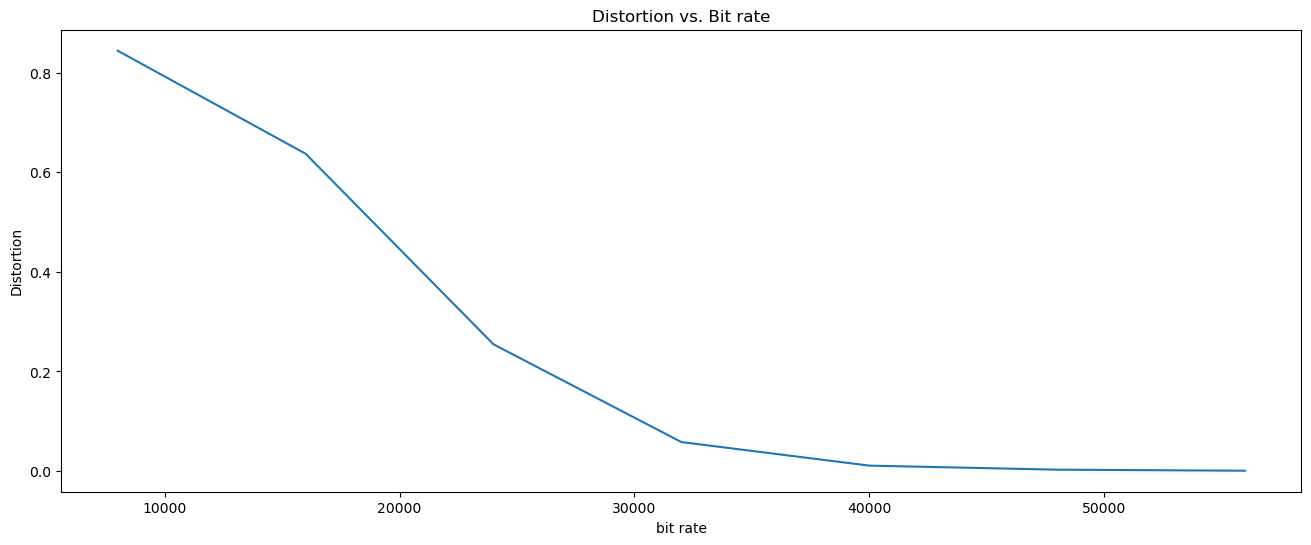

In [195]:
# insert your code here
bits_list = [7,6,5,4,3,2,1]
bit_multi_array = []
rate_dis_array = []

for bits in bits_list:
    quant_speech_error = Uquant(speech, bits)
    error_signal = quant_speech_error - speech
    rate_dis = 1 / ((get_power(quant_speech_error)) / get_power(error_signal))
    bit_multi = (bits * 8000)
    bit_multi_array.append(bit_multi)
    rate_dis_array.append(rate_dis)
    
plt.plot(bit_multi_array, rate_dis_array)
plt.xlabel("bit rate")
plt.ylabel("Distortion")
plt.title("Distortion vs. Bit rate")


## 3.7. Image Quantization
In this section, we will investigate a diﬀerent type of quantizer which produces less noise for a fixed number of quantization levels. As an example, let’s assume the input range for our signal is $[-1,1]$, but most of the input signal takes on values between $[-0.2, 0.2]$. If we place more of the quantization levels closer to zero, we can lower the average error due to quantization.

A common measure of quantization error is mean squared error (noise power). The **Max quantizer** is designed to minimize the mean squared error for a given set of training data. We will study how the Max quantizer works and compare its performance to that of the uniform quantizer, which was used in the previous sections.

### Derivation
The Max quantizer determines quantization levels based on a data set’s probability density function $f(x)$ and the number of desired levels $N$. It minimizes the mean squared error $\epsilon$ between the original and quantized signals:
$$\epsilon = \sum_{k=1}^N \int_{x_k}^{x_{k+1}} (q_k - x)^2 f(x)\; dx$$

where $q_k$ is the $k$-th quantization level and $x_k$ is the lower boundary for $q_k$. The error $\epsilon$ depends on both $q_k$ and $x_k$. (Note that for Gaussian noise, $x_1 = -\infty$ and $x_{N+1} = \infty$. To minimize $\epsilon$ with respect to $q_k$, we must take $\frac{\partial \epsilon}{\partial q_k}$ and solve for $q_k$:
$$q_k = \frac{ \int_{x_k}^{x_{k+1}} x f(x)\; dx }{ \int_{x_k}^{x_{k+1}} f(x)\; dx }$$

We will need the quantization boundaries $x_k$. Solving $\frac{\partial \epsilon}{\partial x_k} = 0$ yields
$$x_k = \frac{ q_{k-1} + q_k }{ 2 }$$

This means that each non-infinite boundary is exactly halfway in between the two adjacent quantization levels, and that each quantization level is at the centroid of its region. The figure below shows a five-level quantizer for a Gaussian distributed signal. Note that the levels are closer together in areas of higher probability.

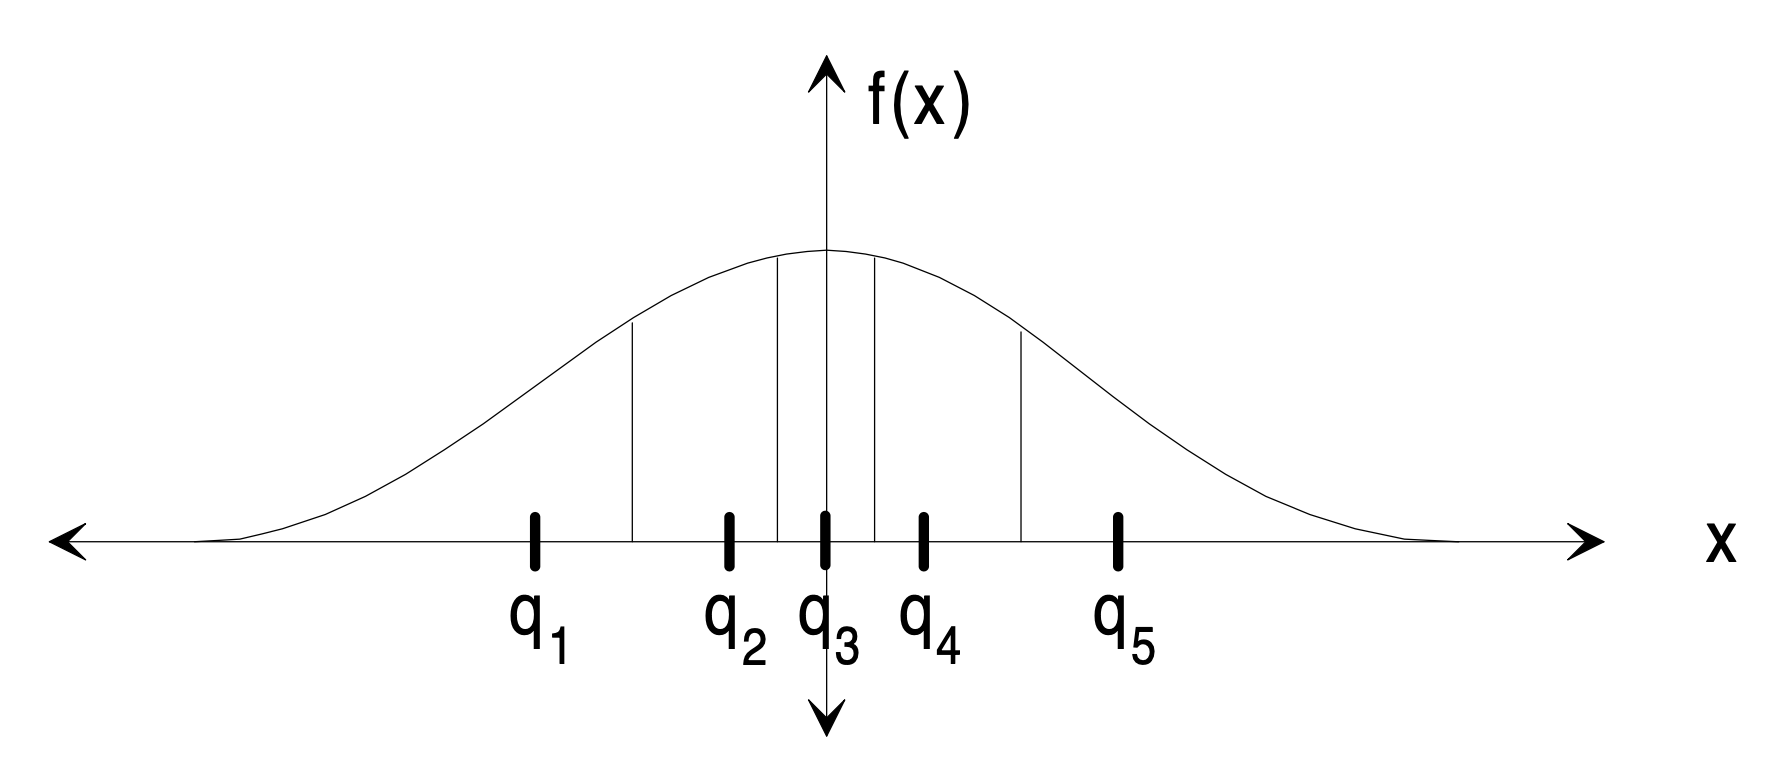

### Implementation, Error Analysis, and Comparison
In this section we will write code to compute an optimal quantizer, and compare its performance to the uniform quantizer. Since we almost never know the actual probability density function of the data that the quantizer will be applied to, we cannot use the above equations to compute the optimal quantization levels. Therefore, a numerical optimization procedure is used on a training set of data to compute the quantization levels and boundaries which yield the smallest possible error for that set.

A Python function `lloyds` that performs this optimization has been provided in the `helper.py` file. Its syntax is:
```partition, codebook = lloyds(training_set, initial_codebook)```

This function requires two inputs. The first is the training dataset `training_set`, from which it will estimate the probability density function. The second is a vector `initial_codebook`, containing an initial guess of the optimal quantization levels. It returns the quantized signal `quantized_signal`.

Since this algorithm minimizes the error with respect to the quantization levels, it is necessary to provice a decent initial guess of the codebook is necessary to help ensure a valid result. If the initial codebook is significantly "far" away from the optimal solution, it is possible that the optimization will get trapped in a local minimum, and the resultant codebook may perform quite poorly. In order to make a good guess, we may first estimate the shape of the probability density function of the training set using a histogram. The idea is to divide the histogram into equal "areas" and choose quantization levels as the centers of each of these segments.

## 3.8. Exercise: Image Quantization

**1. First plot a $40$-bin histogram of this speech signal using ```plt.hist(speech, bins=40)```, and make an initial guess of the four optimal quantization levels. Print out the histogram and the initial guess of the quantization levels.**

Initial guess of quantization levels [-0.15, -0.03, 0.03, 0.15]


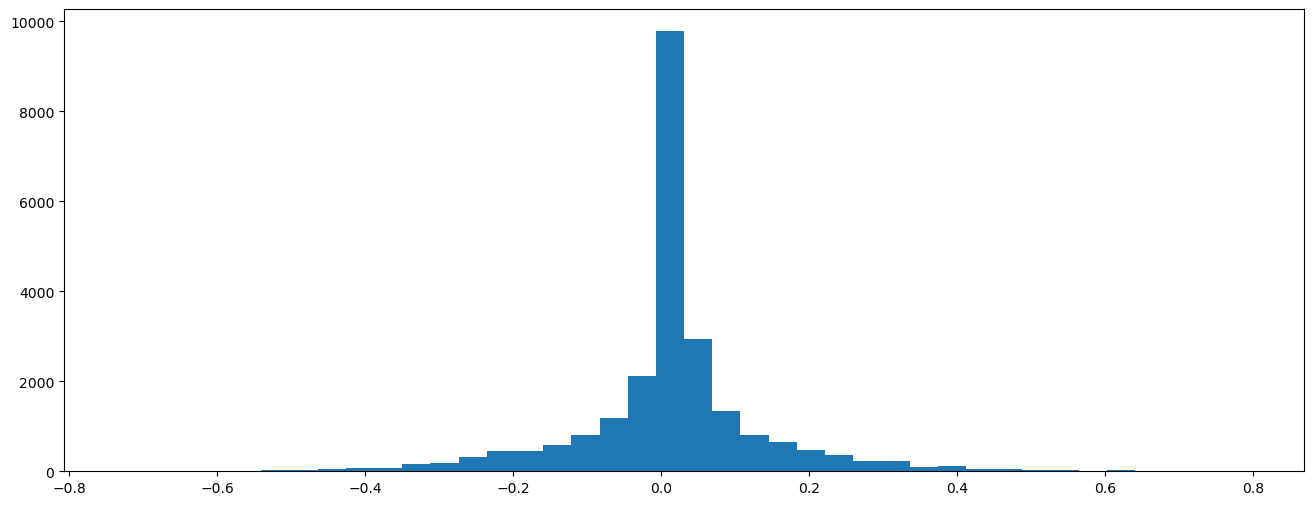

In [196]:
# insert your code here
plt.hist(speech, bins=40)
qk = [-0.15,-0.03, 0.03, 0.15]
print("Initial guess of quantization levels", qk)

**2. Use the function ```lloyds()``` to compute an optimal $4$-level codebook using `speech.au` as the training set.**

In [197]:
# insert your code here
div, q_recon = lloyds(speech, qk)
print("Partition is", div)
print("Codebook is ", q_recon)

Partition is [-0.17850946 -0.02719163  0.14630286]
Codebook is  [-0.27381915 -0.08319978  0.02881651  0.26378921]


**3. Once the optimal codebook is obtained, use the `codebook` and `partition` vectors to quantize the speech signal.**

* This may be done with a *for* loop and *if* statements.

In [198]:
# insert your code here
codebook = np.array(q_recon)
partition = np.array(div)
store_quant = np.zeros_like(speech)

for idx, val in enumerate(speech):
    if val < partition[0]:
        store_quant[idx] = codebook[0]
    elif val < partition[1] and val >= partition[0]:
        store_quant[idx] = codebook[1]
    elif val < partition[2] and val >= partition[1]:
        store_quant[idx] = codebook[2]
    elif val >= partition[2]:
        store_quant[idx] = codebook[3]

    
        

**4. Compute the error signal and PSNR.**

In [199]:
# insert your code here
Error = store_quant - speech
mean_Error = np.mean(Error**2)
mean_Quant = np.sum(store_quant**2) / len(store_quant)
PSNR = mean_Quant / mean_Error
print("Mean_error", mean_Error)
print("PSNR", PSNR)

Mean_error 0.0029983687603521002
PSNR 4.597202419804747


**5. Plot the histogram in Q1 again. However, on this histogram plot, also mark where the optimal quantization levels fall along the $x$-axis.**

* To draw a vertical line, use `plt.axvline(x=0.8, color='r')` to plot a vertical line $x=0.8$ of red color.

Text(0.5, 1.0, '40 bin historgram of speech signal with codebook')

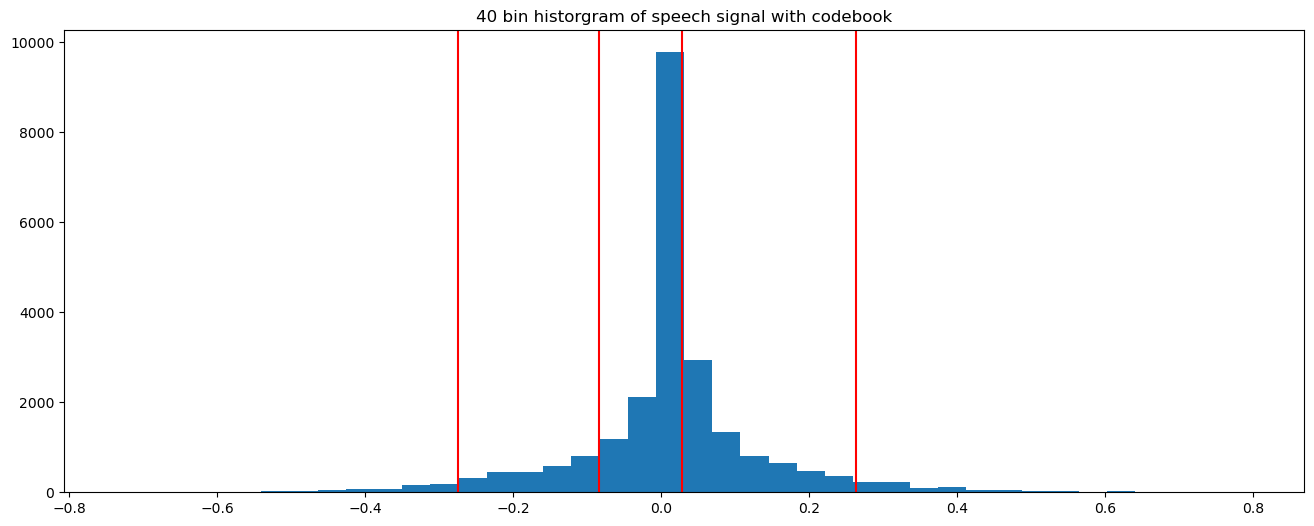

In [200]:
# insert your code here
plt.hist(speech, bins=40)

for q in q_recon:
    plt.axvline(x=q, color='r')
plt.title("40 bin historgram of speech signal with codebook")

**6. Play the quantized audio, and compare the sound quality of the uniform- and max-quantized signals.**

In [201]:
# insert your code here
uniform_quant_speech = Uquant(speech, 2)
display(ipd.Audio(uniform_quant_speech, rate=fs_speech))
display(ipd.Audio(store_quant, rate=fs_speech))
# When listening to both the uniformly quantized and max-quantized signals, the latter demonstrated noticeably better audio quality. 
# The speech produced by uniform quantization contained a significant amount of noise and was barely understandable. 
# In contrast, the max-quantized signal used quantization levels that minimize the mean squared quantization error (MSQE), 
# resulting in a higher PSNR. As a result, the max-quantized signal preserved the speech content more effectively and reduced audible noise.

**7. If the speech signal was uniformly distributed, would the two quantizers be the same? Explain your answer.**

If the speech signal was uniformly distributed, the two quantinzers will be same. It causes max-quantized signals to minimize MSQE resulting in evenly distributed levels and boundaries since all signals are equally placed.